In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns

# Plot 1: Errors from Binomial De-Americanization for different interest rates

In [26]:
# Data
dataPath = './Data/'
rates = np.array([0.02, 0.03, 0.05, 0.1])
testSetDict = {}
for r in rates:
    T =2
    testSetDict[f'{r}'] = pd.read_pickle(dataPath + 'testSet_' + f'data_r_{r}_T_{T}' + '.pkl')

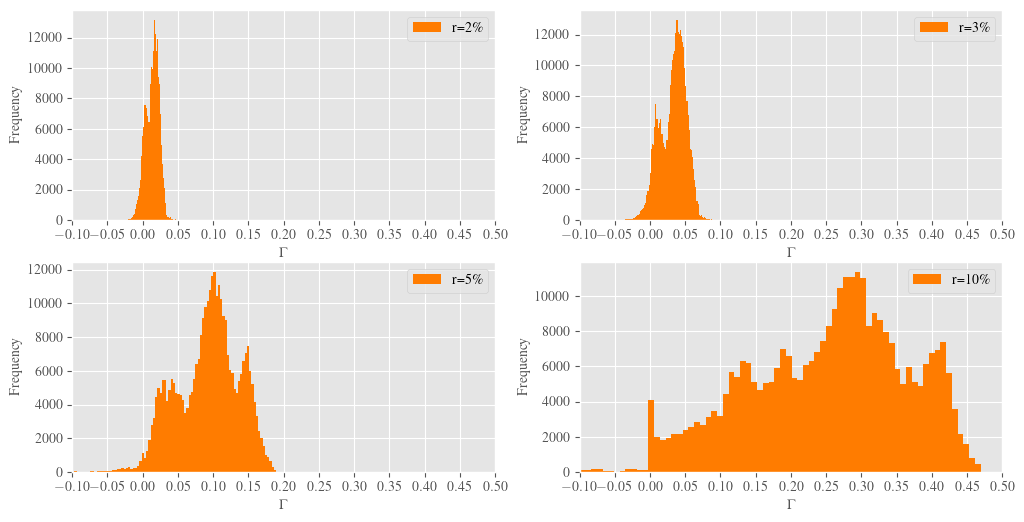

In [27]:
plt.style.use('ggplot')
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.serif': ['Times', 'Palatino', 'Computer Modern Roman']
})
custom_palette = sns.color_palette("bright")  
fig = plt.figure(figsize=(12, 6))
ax = fig.subplot_mosaic("""AB
                           CD""")
## Set x-limits
x_limits = (-0.1, 0.5)
ax['A'].set_xlim(x_limits)
ax['B'].set_xlim(x_limits)
ax['C'].set_xlim(x_limits)
ax['D'].set_xlim(x_limits)

# Set the number of bins to 50 for each histogram
num_bins = 100
for i, key in enumerate(ax.keys()):
    df = testSetDict[f'{rates[i]}']
    df = df[(df['k'] <= 0) & (df['k'] >= -1)]
    ax[key].hist((df['American']-df['BSAmerican'])/df['American'], alpha=1.0, color=custom_palette[1], label=f'r={int(100*rates[i])}\%', bins=num_bins)
    #ax[key].hist((testSetDict[f'{rates[i]}']['American']-testSetDict[f'{rates[i]}']['BSAmerican'])/testSetDict[f'{rates[i]}']['American'], alpha=0.7, color=custom_palette[0], label=f'r={rates[i]}', bins=num_bins)

# Add legends to each subplot
for key in ax.keys():
    ax[key].legend(loc='upper right')

# Set x-axis and y-axis labels for each subplot
for key in ax.keys():
    ax[key].set_xlabel(r'$\Gamma$', fontsize=10)  # X-axis label
    ax[key].set_ylabel('Frequency', fontsize=10)  # Y-axis label

# Set the x-axis ticks with a spacing of 0.05
for key in ax.keys():
    ax[key].xaxis.set_major_locator(ticker.MultipleLocator(base=0.05))
# Add a title to the entire figure
#plt.suptitle('Histograms of Binomial De-Americanization Percentage Errors for Different Rates', fontsize=14)
    
#plt.savefig('./jupyterNoteBooks/plots/hist_error_Binomial_rates_noZoom.pdf', format='pdf', bbox_inches='tight')  # For EPS format

plt.show()

# How well does the NN out-of-sample in a 5 % environment? 

## Retrive Data

In [28]:
# Data
r = 0.05
T = 2 
trainSet = pd.read_pickle(dataPath + 'trainSet_' + f'data_r_{r}_T_{T}' + '.pkl')
trainSet = trainSet[['EEPrem', 'k', 'rho', 'eta', 'gam', 'v', "vp", 'theta']]
testSet = pd.read_pickle(dataPath + 'testSet_' + f'data_r_{r}_T_{T}' + '.pkl')

X_train = trainSet[['rho', 'eta', 'gam', 'v', "vp", 'theta', 'k']]
y_train= trainSet['EEPrem'] 

In [29]:
##Normalize
norm_X_train = (X_train - X_train.mean()) / (X_train.std()+ 1e-8)
norm_y_train = (y_train - y_train.mean()) / (y_train.std()+ 1e-8)

In [30]:
##Normalize testSet
X_test = testSet[['rho', 'eta', 'gam', 'v', "vp", 'theta', 'k']]
y_test = testSet[['EEPrem']]
norm_X_test = (X_test - X_train.mean()) / (X_train.std()+ 1e-8)
norm_y_test = (X_test - X_train.mean()) / (X_train.std()+ 1e-8)

# Load Pretrained Model

In [31]:
regPath = './regModels/'
model_name = f'4000_epochs_bayS_feedforward_NN_r_{r}_T_{T}'
#model.save(regPath + 'models/' + model_name + '.keras')
regModel = keras.models.load_model(regPath + 'models/' + model_name + '.keras')

In [32]:
regModel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 7)]               0         
                                                                 
 dense (Dense)               (None, 40)                320       
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dense_2 (Dense)             (None, 40)                1640      
                                                                 
 dense_3 (Dense)             (None, 40)                1640      
                                                                 
 dense_4 (Dense)             (None, 1)                 41        
                                                                 
Total params: 5281 (20.63 KB)
Trainable params: 5281 (20.63 K

# Predict EE Prem on Test Data

In [33]:
#eeReg = regModel.predict(norm_X_test[['rho', 'eta', 'gam', 'v', "vp", 'theta', 'k']]) * (y_train.std()+ 1e-8) + y_train.mean()
eeReg = regModel.predict(norm_X_test[['rho', 'eta', 'gam', 'v', "vp", 'theta', 'k']]) * (y_train.std()+ 1e-8) + y_train.mean()

40407/40407 [==============================] - 46s 1ms/step


# 2. Plot: Histogram Comparison of EE Prem Error 

In [34]:
regAmer = eeReg[:,0] + testSet['BSEuro']

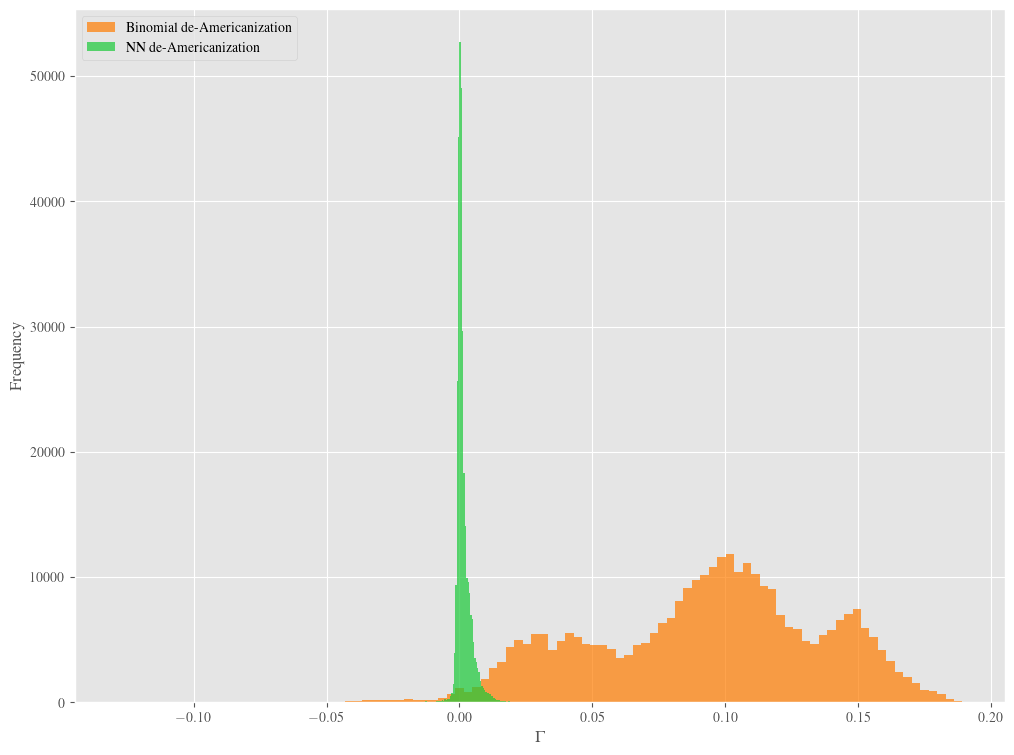

In [35]:
data1 = (testSet[(testSet['k'] <= 0) & (testSet['k'] >= -1)]['American']-testSet[(testSet['k'] <= 0) & (testSet['k'] >= -1)]['BSAmerican'])/testSet[(testSet['k'] <= 0) & (testSet['k'] >= -1)]['American']
data2 = (testSet[(testSet['k'] <= 0) & (testSet['k'] >= -1)]['American']-regAmer[(testSet['k'] <= 0) & (testSet['k'] >= -1)])/testSet[(testSet['k'] <= 0) & (testSet['k'] >= -1)]['American']
custom_palette = sns.color_palette("bright")  

plt.style.use('ggplot')
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.serif': ['Times', 'Palatino', 'Computer Modern Roman']
})
plt.figure(figsize=(12, 9))
plt.hist(data1, bins=100, alpha=0.7, color=custom_palette[1] ,label='Binomial de-Americanization')
plt.hist(data2, bins=100, alpha=0.7, color=custom_palette[2] ,label='NN de-Americanization')

# Add labels, title, and legend
plt.xlabel(r'$\Gamma$')
plt.ylabel('Frequency')
plt.legend(loc='upper left')

#plt.ylim(0,1*10**4)

# Save the plot as a PDF or EPS file
#plt.savefig('./jupyterNoteBooks/plots/histogram_comparison.pdf', format='pdf', bbox_inches='tight')  # For EPS format
# Show the plot
plt.show()

# 3. Plot: Shape of EE Curve

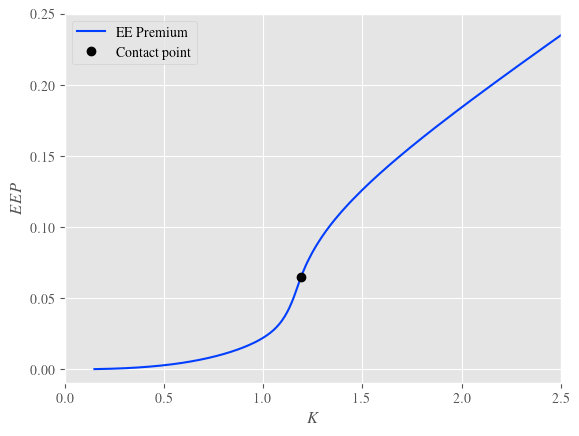

In [36]:
rowNum = abs((testSet[testSet['k']<=0]['BSAmerican']-testSet[testSet['k']<=0]['American'])/(testSet[testSet['k']<=0]['American'])).idxmax()
rowLower = rowNum//1000 * 1000
#plt.plot(testSet['k'].loc[rowLower : rowLower+999],testSet['BS_EEPrem'].loc[rowLower : rowLower+999], color='red', linestyle='dashed', label='Binom EE Premium')
plt.style.use('ggplot')
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.serif': ['Times', 'Palatino', 'Computer Modern Roman']
})
plt.plot(np.exp(testSet['k'].loc[rowLower : rowLower+999])*np.exp(2*0.05),testSet['EEPrem'].loc[rowLower : rowLower+999], color=custom_palette[0], linestyle='solid', label='EE Premium')

#contact point
contactPointIdx = ( (testSet['American'].loc[rowLower : rowLower+999] - np.maximum(0, np.exp(testSet['k'].loc[rowLower : rowLower+999]) * np.exp(2 * 0.05) - 1 ) ) < 1e-10 ).idxmax()
plt.plot(np.exp(testSet.loc[contactPointIdx]['k'])*np.exp(2*0.05), testSet.loc[contactPointIdx]['EEPrem'], 'ko', label='Contact point')

# Add labels, title, and legend
plt.xlabel(r'$K$')
plt.ylabel(r'$EEP$')
#plt.title('Early Exercise Premium Estimate in the Local Volatility and Black-Scholes Model')
plt.legend(loc='upper left')
plt.xlim(0.0,2.5)
plt.ylim(-0.01, 0.25)


#plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1)) # move outside box
# Save the plot as a PDF or EPS file
#plt.savefig('./jupyterNoteBooks/plots/EE_Prem.pdf', bbox_inches='tight')  # For PDF format
#plt.savefig('./jupyterNoteBooks/plots/EE_Prem.eps', format='eps', bbox_inches='tight')  # For EPS format
# Show the plot
plt.show()

# Worst Performance Binomial De-Americanization

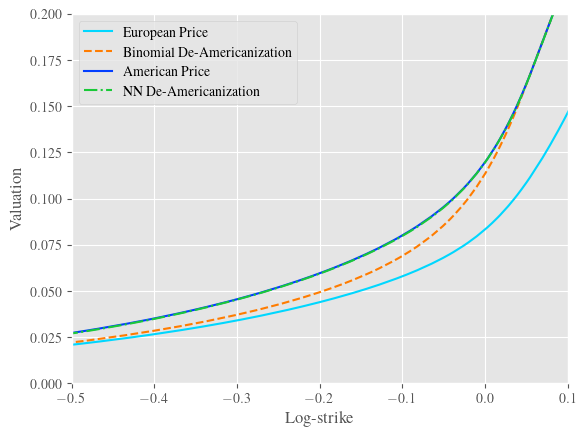

In [38]:
rowNum = abs((testSet[testSet['k']<=0]['BSAmerican']-testSet[testSet['k']<=0]['American'])/(testSet[testSet['k']<=0]['American'])).idxmax()
rowLower = rowNum//1000 * 1000
plt.plot(testSet['k'].loc[rowLower : rowLower+999],testSet['BSEuro'].loc[rowLower : rowLower+999], color=custom_palette[9], linestyle='solid', label='European Price')
plt.plot(testSet['k'].loc[rowLower : rowLower+999],testSet['BSAmerican'].loc[rowLower : rowLower+999], color=custom_palette[1], linestyle='dashed', label='Binomial De-Americanization')
plt.plot(testSet['k'].loc[rowLower : rowLower+999],testSet['American'].loc[rowLower : rowLower+999], color=custom_palette[0], linestyle='solid', label='American Price')
plt.plot(testSet['k'].loc[rowLower : rowLower+999],regAmer.loc[rowLower : rowLower+999], color=custom_palette[2], linestyle='dashdot', label='NN De-Americanization')
#plt.plot(testSet[['k']].loc[rowLower : rowLower+999], regAmer.loc[rowLower : rowLower+999], color='Blue', label='NN De-Americanization') 

# Add labels, title, and legend
plt.xlabel('Log-strike')
plt.ylabel('Valuation')
#plt.title('Early Exercise Premium Estimate in the Local Volatility and Black-Scholes Model')
plt.legend(loc='upper left')
plt.xlim(-0.5,0.1)
plt.ylim(0.0, 0.2)

#plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1)) # move outside box
# Save the plot as a PDF or EPS file
#plt.savefig('./jupyterNoteBooks/plots/worst_fit_Binomial_test_price_error_r_0.05_T_2.pdf', bbox_inches='tight')  # For PDF format
#plt.savefig('./jupyterNoteBooks/plots/EE_Prem.eps', format='eps', bbox_inches='tight')  # For EPS format
# Show the plot
plt.show()

# Worst Performance NN De-Americanization

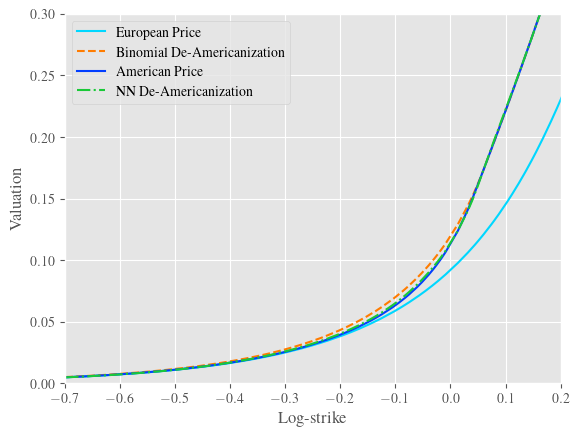

In [40]:
rowNum = abs((regAmer[(testSet['k'] <= 0) & (testSet['k'] >= -1)]-testSet[(testSet['k'] <= 0) & (testSet['k'] >= -1)]['American'])/(testSet[(testSet['k'] <= 0) & (testSet['k'] >= -1)]['American'])).idxmax()
rowLower = rowNum//1000 * 1000
plt.plot(testSet['k'].loc[rowLower : rowLower+999],testSet['BSEuro'].loc[rowLower : rowLower+999], color=custom_palette[9], linestyle='solid', label='European Price')
plt.plot(testSet['k'].loc[rowLower : rowLower+999],testSet['BSAmerican'].loc[rowLower : rowLower+999], color=custom_palette[1], linestyle='dashed', label='Binomial De-Americanization')
plt.plot(testSet['k'].loc[rowLower : rowLower+999],testSet['American'].loc[rowLower : rowLower+999], color=custom_palette[0], linestyle='solid', label='American Price')
plt.plot(testSet['k'].loc[rowLower : rowLower+999],regAmer.loc[rowLower : rowLower+999], color=custom_palette[2], linestyle='dashdot', label='NN De-Americanization')
#plt.plot(testSet[['k']].loc[rowLower : rowLower+999], regAmer.loc[rowLower : rowLower+999], color='Blue', label='NN De-Americanization') 

# Add labels, title, and legend
plt.xlabel('Log-strike')
plt.ylabel('Valuation')
#plt.title('Early Exercise Premium Estimate in the Local Volatility and Black-Scholes Model')
plt.legend(loc='upper left')
plt.xlim(-0.7,0.2)
plt.ylim(0.0, 0.3)

#plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1)) # move outside box
# Save the plot as a PDF or EPS file
#plt.savefig('./jupyterNoteBooks/plots/worst_fit_NN_test_price_error_r_0.05_T_2.pdf', bbox_inches='tight')  # For PDF format
#plt.savefig('./jupyterNoteBooks/plots/EE_Prem.eps', format='eps', bbox_inches='tight')  # For EPS format
# Show the plot
plt.show()

# Comparision of Out-of-Money NN De-Americanization and Binomial De-Americanization

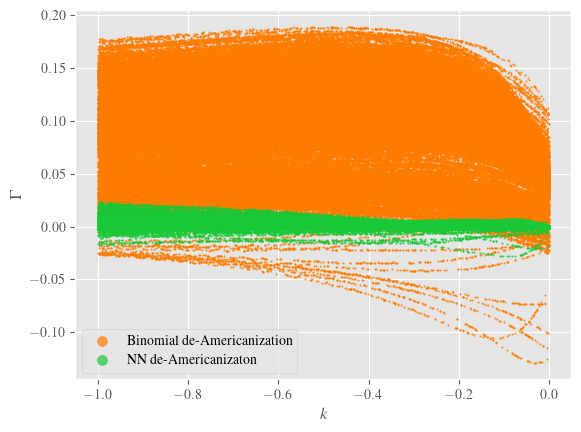

In [46]:
test_OTM = testSet[(testSet['k'] <= 0) & (testSet['k'] >= -1)]

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.serif': ['Times', 'Palatino', 'Computer Modern Roman']
})

# Downsample the data
sampled_data = test_OTM.sample(n=323096)  # Adjust the number of samples as needed

# Get the index values of sampled_data
sampled_data_indices = sampled_data.index

# Filter regAmer using the sampled_data_indices
filtered_regAmer = regAmer.loc[sampled_data_indices]

# Calculate percentage error for both sets of data
percentage_error_sampled = (sampled_data['American'] - sampled_data['BSAmerican']) / sampled_data['American']
percentage_error_filtered = (sampled_data['American'] - filtered_regAmer) / sampled_data['American']

# Scatter plot for the first set of data (sampled_data) in blue
plt.scatter(sampled_data['k'], percentage_error_sampled, marker='o', s=1, alpha=0.7, color=custom_palette[1], label='Binomial de-Americanization')

# Scatter plot for the second set of data (filtered_regAmer) in red
plt.scatter(sampled_data['k'], percentage_error_filtered, marker='o', s=1, alpha=0.7, color=custom_palette[2], label='NN de-Americanizaton')

# Customize plot labels, legend, and colorbar
plt.xlabel(r'$k$')
plt.ylabel(r'$\Gamma$')

# Customize the legend
lgnd = plt.legend(loc="lower left", scatterpoints=1, fontsize=10)
for handle in lgnd.legend_handles:
    handle.set_sizes([50.0])
    
# Save the plot as a PDF
#plt.savefig('./jupyterNoteBooks/plots/scatter_test_price_error_r_0.05_T_2.pdf', bbox_inches='tight')

# Show the plot
plt.show()

### Numerical Values

In [51]:
## Numerical Values
print(f"Mean relative error NN de-Americanization: {np.mean( (test_OTM['American']-regAmer[(testSet['k'] <= 0) & (testSet['k'] >= -1)])/test_OTM['American'] )}, Mean relative error binomial de-Americanization: {np.mean((test_OTM['American']-test_OTM['BSAmerican'])/test_OTM['American'])}")

Mean relative error NN de-Americanization: 0.001404893742111189, Mean relative error binomial de-Americanization: 0.09239988946655177


In [52]:
print(f"Maximum relative error NN de-Americanization: {np.max(abs( (test_OTM['American']-regAmer[(testSet['k'] <= 0) & (testSet['k'] >= -1)])/test_OTM['American'] ) )}, Maximum relative error binomial de-Americanization: {np.max(abs((test_OTM['American']-test_OTM['BSAmerican'])/test_OTM['American']))}")

Maximum relative error NN de-Americanization: 0.028218024766974978, Maximum relative error binomial de-Americanization: 0.18934370532257994


# Calibration Performance